<a href="https://colab.research.google.com/github/longchung2002/FLOWER-framework-simulation-poisonGAN/blob/main/simv1.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

In [32]:
!pip install matplotlib

In [33]:
from datasets import Dataset
from flwr_datasets import FederatedDataset
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import TensorDataset

# Let's set a simulation involving a total of 100 clients
NUM_CLIENTS = 33

# Download MNIST dataset and partition the "train" partition (so one can be assigned to each client)
mnist_fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
# Let's keep the test set as is, and use it to evaluate the global model on the server
centralized_testset = mnist_fds.load_split("test")
partition = mnist_fds.load_partition(0, "train")
partition.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

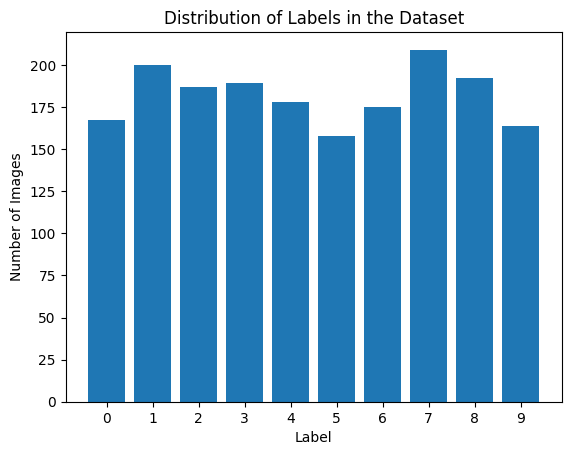

In [34]:
import matplotlib.pyplot as plt
def calculate_label_distribution(data_loaders):
    label_counts = {}
    for loader in data_loaders:
        images = loader["image"]
        labels = [loader["label"]]
        for label in labels:
            label = int(label)
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
    return label_counts

def plot_label_distribution(label_counts):
    # Vẽ biểu đồ histogram
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Labels in the Dataset')
    plt.xticks(range(10))
    plt.show()
    # Tính toán phân phối nhãn từ tất cả các dataloader
all_trainloaders = partition # Gộp tất cả các dataloader lại
all_label_counts = calculate_label_distribution(all_trainloaders)

# Vẽ biểu đồ tương quan giữa tất cả các dataloader
plot_label_distribution(all_label_counts)

In [35]:
from torchvision.transforms import ToTensor, Normalize, Compose, Resize


def apply_transforms(batch):
    """Get transformation for MNIST dataset"""

    # transformation to convert images to tensors and apply normalization
    transforms = Compose([
        ToTensor(),
        Normalize((0.5,), (0.5,))
        ])
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)) #26x26x32
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) #13x13x32

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 11)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.softmax(x)
        return x
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)) #26x26x32
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) #13x13x32

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)) #10x10
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 11)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.pool2(self.batchnorm2(self.relu2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 64 * 5 * 5)
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=2, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.leaky1 = nn.LeakyReLU()

        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=2, padding=0)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 64, 5, 5)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.leaky1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leaky2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x

In [37]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
def train(net, trainloader, optim, scheduler, criterion, epochs, device: str):
    """Train the network on the training set."""
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
        scheduler.step()

def test_standard(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / len(testloader.dataset)
    return loss, accuracy


In [38]:
import flwr as fl

In [39]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, valloader, testloader) -> None:
        super().__init__()
        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.cid = cid
        self.model = Model()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        # print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        optim = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test_standard(self.model, self.valloader, device=self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [40]:
import glob
import os
def load_model_state_dict():
    net = Model()
    list_of_files = [fname for fname in glob.glob("./model_round_*")]
    latest_round_file = max(list_of_files, key=os.path.getctime)
    # latest_round_file = './model_round_df.pth'
    print("Loading pre-trained model from: ", latest_round_file)
    state_dict = torch.load(latest_round_file)
    net.load_state_dict(state_dict)
    return net

In [41]:
def get_evaluate_fn(centralized_testset: Dataset):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Model()

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        ###############################################################################
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # model = load_model_state_dict()
        # model.to(device)
        ###############################################################################
        # Apply transform to dataset
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # call test
        loss, accuracy = test_standard(model, testloader, device)
        print('GLOBAL TEST')
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [42]:
from flwr.common import Metrics, FitRes

def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.1,  # Learning rate to use by clients during fit()
        "attacker_epochs": 20,
        "attacker_lr": 0.2,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [43]:
import numpy as np
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""
        model = Model()
        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(model.state_dict(), f"model_round_{server_round}.pth")
        return aggregated_parameters, aggregated_metrics

In [44]:
strategy = SaveModelStrategy(
    fraction_fit=0.31,  # Sample 10% of available clients for training
    fraction_evaluate=0.31,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

In [45]:
from torch.utils.data import DataLoader


def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Let's get the partition corresponding to the i-th client
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"]
        valset = client_dataset_splits["test"]

        # Now we apply the transform to each batch.
        trainloader = DataLoader(
            trainset.with_transform(apply_transforms), batch_size=256, shuffle=True
        )
        valloader = DataLoader(valset.with_transform(apply_transforms), batch_size=256)
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # Create and return client
        return FlowerClient(int(cid), trainloader, valloader, testloader).to_client()

    return client_fn


client_fn_callback = get_client_fn(mnist_fds)

Now we are ready to launch the FL experiment using Flower simulation:

In [46]:
# # With a dictionary, you tell Flower's VirtualClientEngine that each
# # client needs exclusive access to these many resources in order to run
# client_resources = {"num_cpus": 0.2, "num_gpus": 0.1}

# # Let's disable tqdm progress bar in the main thread (used by the server)
# disable_progress_bar()

# history = fl.simulation.start_simulation(
#     client_fn=client_fn_callback,  # a callback to construct a client
#     num_clients=NUM_CLIENTS,  # total number of clients in the experiment
#     config=fl.server.ServerConfig(num_rounds=100),  # let's run for 10 rounds
#     strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
#     client_resources=client_resources,
#     actor_kwargs={
#         "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
#     },
# )

In [47]:
# import matplotlib.pyplot as plt

# print(f"{history.metrics_centralized = }")

# global_accuracy_centralised = history.metrics_centralized["accuracy"]
# round = [data[0] for data in global_accuracy_centralised]
# acc = [data[1] for data in global_accuracy_centralised]
# plt.plot(round, acc)
# plt.grid()
# plt.ylabel("Accuracy (%)")
# plt.xlabel("Round")
# plt.title("MNIST - IID - 33 clients with 10 clients per round")

Congratulations! With that, you built a Flower client, customized it's instantiation through the `client_fn`, customized the server-side execution through a `FedAvg` strategy configured for this workload, and started a simulation with 100 clients (each holding their own individual partition of the MNIST dataset).

Next, you can continue to explore more advanced Flower topics:

- Deploy server and clients on different machines using `start_server` and `start_client`
- Customize the server-side execution through custom strategies
- Customize the client-side execution through `config` dictionaries

Get all resources you need!

* **[DOCS]** Our complete documenation: https://flower.dev/docs/
* **[Examples]** All Flower examples: https://flower.dev/docs/examples/
* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.dev/join-slack/


In [48]:
def get_evaluate_fn(centralized_testset: Dataset):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Model()

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        ###############################################################################
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # model = load_model_state_dict()
        # model.to(device)
        ###############################################################################
        # Apply transform to dataset
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # call test
        loss, accuracy = test(model, testloader, device)
        print('GLOBAL TEST')
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [49]:
import random
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
def save_images(images, folder_path, prefix):
    # Find the existing files to determine the count
    existing_files = glob.glob(os.path.join(folder_path, f"{prefix}_*.png"))
    count = len(existing_files) + 1

    # Assuming images are square, adjust size if needed
    image_size = images.shape[1]

    plt.figure(figsize=(8, 8))

    for i, img in enumerate(images):
        plt.subplot(4, 4, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
        plt.axis('off')

    # Save the combined image with a dynamic filename
    filename = f"{prefix}_{count}.png"
    plt.savefig(os.path.join(folder_path, filename))
    plt.close()


def plot_generated(generator, save_folder, num_images=16, device='cuda'):
    noise = torch.randn(num_images, 100).to(device)
    generated_images = generator(noise)
    generated_images = generated_images.squeeze().cpu().detach().numpy()

    # Save the combined image
    save_images(generated_images, save_folder, "random_image")


In [50]:
main_loss_values = []
main_acc_values = []
standard_loss_values = []
standard_acc_values = []

In [51]:
def test_other_classes(net, testloader, device: str):
    """Validate the network on the entire test set excluding class 2."""
    criterion = torch.nn.CrossEntropyLoss()
    correct_non_poisoned = 0
    total_non_poisoned = 0
    loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)

            # Exclude class 2
            non_poisoned_mask = labels != 2
            images_non_poisoned = images[non_poisoned_mask]
            labels_non_poisoned = labels[non_poisoned_mask]

            output = net(images_non_poisoned)
            pred = output.argmax(dim=1, keepdim=True)

            for i in range(len(labels_non_poisoned)):
                if pred[i].item() == labels_non_poisoned[i].item():
                    correct_non_poisoned += 1
                total_non_poisoned += 1

            loss += criterion(output, labels_non_poisoned).item()

    non_poisoned_accuracy = 100 * correct_non_poisoned / total_non_poisoned if total_non_poisoned != 0 else 0
    return loss, non_poisoned_accuracy


In [52]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct_poisoned = 0
    total_poisoned = 0
    loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            output = net(images)
            pred = output.argmax(dim=1, keepdim=True)
            for i in range(len(labels)):
                if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
                    correct_poisoned += 1
                if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
                    total_poisoned += 1
            loss += criterion(output, labels).item()
    poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
    # print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
    main_loss, main_acc = test_other_classes(net, testloader, device)
    standard_loss, standard_acc = test_standard(net, testloader, device)

    main_loss_values.append(main_loss)
    main_acc_values.append(main_acc)
    standard_loss_values.append(standard_loss)
    standard_acc_values.append(standard_acc)
    return loss, poisoned_accuracy

In [53]:
from tqdm.notebook import tqdm
import torch
def poisontrain(net, generator, discriminator, trainloader,
          optimizer_net, optimizer_g, optimizer_d,
          scheduler_net, scheduler_g, scheduler_d,
          criterion, criterion_d, epochs, device: str):
    """Train the network on the training set."""
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            # Train discriminator with fake images
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise)
            outputs_fake = discriminator(fake_images.detach())
            fake_labels = torch.full((batch_size,), 10).to(device)
            loss_fake = criterion_d(outputs_fake, fake_labels)
            loss_fake.backward()
            d_loss = loss_fake
            optimizer_d.step()

            # Train generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images)
            loss_generator = criterion_d(outputs, labels)
            loss_generator.backward()
            g_loss = loss_generator
            optimizer_g.step()

            outputs = generator(noise)
            predictions = net(outputs)
            predicted_labels = torch.max(predictions, dim=1).indices
            selected_images = outputs[predicted_labels == 2]
            selected_labels = predicted_labels[predicted_labels == 2]
            selected_labels[selected_labels == 2] = 7
            if len(selected_images)>0:
                print('output size: ', outputs.size(0))
                print('selected images size: ', selected_images.size(0))
                optimizer_net.zero_grad()
                outputs = net(selected_images)
                loss = criterion(outputs, selected_labels)
                loss.backward()
                for param in net.parameters():
                    param.grad *= 5
                optimizer_net.step()
        scheduler_net.step()
        # scheduler_g.step()
        # scheduler_d.step()
    save_folder = "content/images"

    # Tạo thư mục nếu nó chưa tồn tại
    os.makedirs(save_folder, exist_ok=True)
    plot_generated(generator, save_folder, num_images=16, device=device)

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
class FlowerClient(FlowerClient):
    def __init__(self, cid, trainloader, valloader, testloader) -> None:
        super().__init__()
        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.cid = cid
        self.model = Model()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to
        self.discriminator = Discriminator()
        self.generator = Generator()

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)
        self.discriminator.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        # print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]

        optimizer_net = torch.optim.SGD(self.model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        scheduler_net = lr_scheduler.StepLR(optimizer_net, step_size=2, gamma=0.1)

        if self.cid in [0, 1, 2]:
            print('ATTACKER')
            attacker_lr, attacker_epochs = config["attacker_lr"], config["attacker_epochs"]
            loss, accuracy = test(self.model, self.testloader, device=self.device)
            criterion_d = torch.nn.CrossEntropyLoss()
            optimizer_g = torch.optim.SGD(generator.parameters(), lr=attacker_lr)
            scheduler_g = lr_scheduler.StepLR(optimizer_g, step_size=2, gamma=0.1)
            optimizer_d = torch.optim.SGD(discriminator.parameters(), lr=attacker_lr)
            scheduler_d = lr_scheduler.StepLR(optimizer_d, step_size=2, gamma=0.1)

            if accuracy > 60:
                train(net=self.model, trainloader=self.trainloader, optim=optimizer_net, scheduler=scheduler_net, criterion=criterion, epochs=epochs, device=self.device)
                poisontrain(self.model, generator, discriminator, self.trainloader,
                          optimizer_net, optimizer_g, optimizer_d,
                          scheduler_net, scheduler_g, scheduler_d,
                          criterion, criterion_d, attacker_epochs, self.device)
            else:
                poisontrain(self.model, generator, discriminator, self.trainloader,
                          optimizer_net, optimizer_g, optimizer_d,
                          scheduler_net, scheduler_g, scheduler_d,
                          criterion, criterion_d, attacker_epochs, self.device)
        else:
            train(net=self.model, trainloader=self.trainloader, optim=optimizer_net, scheduler=scheduler_net, criterion=criterion, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)

        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [55]:
import glob
import os
net = Model()
# list_of_files = [fname for fname in glob.glob("./model_round_*")]
# latest_round_file = max(list_of_files, key=os.path.getctime)
latest_round_file = './model_round_df.pth'
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)

Loading pre-trained model from:  ./model_round_df.pth


<All keys matched successfully>

In [56]:
def get_parameters():
    """Extract all model parameters and conver them to a list of
    NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [57]:
params = get_parameters()

strategy = SaveModelStrategy(
    fraction_fit=0.31,  # Sample 10% of available clients for training
    fraction_evaluate=0.31,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

In [58]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.2, "num_gpus": 0.1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=50),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-10 18:01:34,779	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3845469388.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7690938779.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3845469388.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7690938779.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize y

GLOBAL TEST


(pid=19642) 2024-04-10 18:02:07.989332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19642) 2024-04-10 18:02:07.989389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19642) 2024-04-10 18:02:07.998901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=19856) 2024-04-10 18:02:18.598886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19811) 2024-04-10 18:02:08.667428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when on

(ClientAppActor pid=19855) ATTACKER
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  105
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  1


(ClientAppActor pid=19855) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19855) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19855) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19855) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19855) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19855)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=19750) 2024-04-10 18:02:20.038452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 9x across cluster]
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 1 aggregated_parameters...


INFO :      fit progress: (1, 331.6653048992157, {'accuracy': 2.7131782945736433}, 116.22054640899933)
INFO:flwr:fit progress: (1, 331.6653048992157, {'accuracy': 2.7131782945736433}, 116.22054640899933)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  46
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  107
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  46
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  117
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  89
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  47
(ClientAppActor pid=19750) output size:  101
(ClientAppActor pid=19750) selected images size:  98
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  1
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  1
(ClientAppActor pid=19750) output size:  101
(ClientAppActor pid=19750) selected i

(ClientAppActor pid=19750) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19750) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19750) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19750) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19750) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19750)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 2 aggregated_parameters...


INFO :      fit progress: (2, 329.69378316402435, {'accuracy': 2.7131782945736433}, 188.15795716399953)
INFO:flwr:fit progress: (2, 329.69378316402435, {'accuracy': 2.7131782945736433}, 188.15795716399953)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19811) ATTACKER
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  92
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  3
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  6


(ClientAppActor pid=19811) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19811) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19811) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19811) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19811) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19811)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 3 aggregated_parameters...


INFO :      fit progress: (3, 328.66066789627075, {'accuracy': 2.616279069767442}, 259.1913520019998)
INFO:flwr:fit progress: (3, 328.66066789627075, {'accuracy': 2.616279069767442}, 259.1913520019998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 4 aggregated_parameters...


INFO :      fit progress: (4, 327.39432287216187, {'accuracy': 2.5193798449612403}, 313.6078317769998)
INFO:flwr:fit progress: (4, 327.39432287216187, {'accuracy': 2.5193798449612403}, 313.6078317769998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19811) ATTACKER
(ClientAppActor pid=19734) ATTACKER
(ClientAppActor pid=19795) ATTACKER
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  70
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  77
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  5
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  82
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  67
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  1
(ClientAppActor pid=19795) output size:  256 [repeated 9x across cluster]
(ClientAppActor pid=19795) selected images size:  1 [repeated 9x across cluster]


(ClientAppActor pid=19795) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19795) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19795) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19795) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19795) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19795)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(ClientAppActor pid=19734) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19734) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19734) see the appropriate new directories, set the environment 

Saving round 5 aggregated_parameters...


INFO :      fit progress: (5, 327.8235294818878, {'accuracy': 2.616279069767442}, 412.88719415000014)
INFO:flwr:fit progress: (5, 327.8235294818878, {'accuracy': 2.616279069767442}, 412.88719415000014)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19795) output size:  256 [repeated 2x across cluster]
(ClientAppActor pid=19795) selected images size:  1 [repeated 2x across cluster]
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  55
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  62
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  9
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  54
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  10
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  36
(ClientAppActor pid=19750) output size:  101
(ClientAppActor pid=19750) selected images size:  33
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  16
(ClientAppActor pid=19750)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 6 aggregated_parameters...


INFO :      fit progress: (6, 326.4784759283066, {'accuracy': 2.5193798449612403}, 484.21192106799936)
INFO:flwr:fit progress: (6, 326.4784759283066, {'accuracy': 2.5193798449612403}, 484.21192106799936)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 7 aggregated_parameters...


INFO :      fit progress: (7, 325.42636024951935, {'accuracy': 2.3255813953488373}, 538.4564048429993)
INFO:flwr:fit progress: (7, 325.42636024951935, {'accuracy': 2.3255813953488373}, 538.4564048429993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19855) ATTACKER
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  76
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  44
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  37
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  22
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  25
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  92
(ClientAppActor pid=19855) output size:  101
(ClientAppActor pid=19855) selected images size:  4
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  38
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  78
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected im

INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 8 aggregated_parameters...


INFO :      fit progress: (8, 325.00100445747375, {'accuracy': 2.3255813953488373}, 610.8677319199996)
INFO:flwr:fit progress: (8, 325.00100445747375, {'accuracy': 2.3255813953488373}, 610.8677319199996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19811) ATTACKER
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  55
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  84
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  211
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 9 aggregated_parameters...


INFO :      fit progress: (9, 325.0378350019455, {'accuracy': 2.4224806201550386}, 682.9516894339995)
INFO:flwr:fit progress: (9, 325.0378350019455, {'accuracy': 2.4224806201550386}, 682.9516894339995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 10 aggregated_parameters...


INFO :      fit progress: (10, 323.8922609090805, {'accuracy': 2.3255813953488373}, 737.531122331)
INFO:flwr:fit progress: (10, 323.8922609090805, {'accuracy': 2.3255813953488373}, 737.531122331)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19856) ATTACKER
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  51
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  130
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  3
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  1


(ClientAppActor pid=19856) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=19856) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=19856) see the appropriate new directories, set the environment variable
(ClientAppActor pid=19856) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=19856) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=19856)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 11 aggregated_parameters...


INFO :      fit progress: (11, 323.8068742752075, {'accuracy': 2.4224806201550386}, 809.0361032629999)
INFO:flwr:fit progress: (11, 323.8068742752075, {'accuracy': 2.4224806201550386}, 809.0361032629999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19795) ATTACKER
(ClientAppActor pid=19811) ATTACKER
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  37
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  154
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  40
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  103
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  57
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  23
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  6
(ClientAppActor pid=19811) output size:  256
(ClientAppActor pid=19811) selected images size:  102
(ClientAppActor pid=19811) output size:  101
(ClientAppActor pid=19811) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 12 aggregated_parameters...


INFO :      fit progress: (12, 323.79447889328003, {'accuracy': 2.5193798449612403}, 893.8149796899997)
INFO:flwr:fit progress: (12, 323.79447889328003, {'accuracy': 2.5193798449612403}, 893.8149796899997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 13 aggregated_parameters...


INFO :      fit progress: (13, 322.69351601600647, {'accuracy': 2.3255813953488373}, 948.6448915829997)
INFO:flwr:fit progress: (13, 322.69351601600647, {'accuracy': 2.3255813953488373}, 948.6448915829997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19855) ATTACKER
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  55
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  76
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  61
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  33
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  35
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  64
(ClientAppActor pid=19855) output size:  101
(ClientAppActor pid=19855) selected images size:  25
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  81
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected images size:  28
(ClientAppActor pid=19855) output size:  256
(ClientAppActor pid=19855) selected i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 14 aggregated_parameters...


INFO :      fit progress: (14, 322.54828357696533, {'accuracy': 2.3255813953488373}, 1019.9862897919993)
INFO:flwr:fit progress: (14, 322.54828357696533, {'accuracy': 2.3255813953488373}, 1019.9862897919993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  34
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  41
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  64
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  9
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  26
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  143
(ClientAppActor pid=19750) output size:  101
(ClientAppActor pid=19750) selected images size:  1
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  39
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  3


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 15 aggregated_parameters...


INFO :      fit progress: (15, 329.70398807525635, {'accuracy': 8.430232558139535}, 1091.53724375)
INFO:flwr:fit progress: (15, 329.70398807525635, {'accuracy': 8.430232558139535}, 1091.53724375)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 16]
INFO:flwr:[ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  7


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 16 aggregated_parameters...


INFO :      fit progress: (16, 382.23021268844604, {'accuracy': 30.426356589147286}, 1165.6274525620001)
INFO:flwr:fit progress: (16, 382.23021268844604, {'accuracy': 30.426356589147286}, 1165.6274525620001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 17]
INFO:flwr:[ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19795) ATTACKER


(ClientAppActor pid=19795) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(ClientAppActor pid=19795)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 17 aggregated_parameters...


INFO :      fit progress: (17, 322.71503031253815, {'accuracy': 3.197674418604651}, 1239.4254061149995)
INFO:flwr:fit progress: (17, 322.71503031253815, {'accuracy': 3.197674418604651}, 1239.4254061149995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 18]
INFO:flwr:[ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 18 aggregated_parameters...


INFO :      fit progress: (18, 321.57375621795654, {'accuracy': 2.3255813953488373}, 1293.87156349)
INFO:flwr:fit progress: (18, 321.57375621795654, {'accuracy': 2.3255813953488373}, 1293.87156349)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 19]
INFO:flwr:[ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 19 aggregated_parameters...


INFO :      fit progress: (19, 321.17740738391876, {'accuracy': 2.3255813953488373}, 1348.1537169109997)
INFO:flwr:fit progress: (19, 321.17740738391876, {'accuracy': 2.3255813953488373}, 1348.1537169109997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 20]
INFO:flwr:[ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19856) ATTACKER
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  14


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 20 aggregated_parameters...


INFO :      fit progress: (20, 330.2360624074936, {'accuracy': 12.015503875968992}, 1421.260379026)
INFO:flwr:fit progress: (20, 330.2360624074936, {'accuracy': 12.015503875968992}, 1421.260379026)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 21]
INFO:flwr:[ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER


(ClientAppActor pid=19734) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(ClientAppActor pid=19734)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 21 aggregated_parameters...


INFO :      fit progress: (21, 320.85331904888153, {'accuracy': 2.616279069767442}, 1494.3067935119998)
INFO:flwr:fit progress: (21, 320.85331904888153, {'accuracy': 2.616279069767442}, 1494.3067935119998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 22]
INFO:flwr:[ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19856) ATTACKER


(ClientAppActor pid=19856) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(ClientAppActor pid=19856)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


(ClientAppActor pid=19856) output size:  101
(ClientAppActor pid=19856) selected images size:  1
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  1
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  1
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  1
(ClientAppActor pid=19856) output size:  256
(ClientAppActor pid=19856) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 22 aggregated_parameters...


INFO :      fit progress: (22, 320.5139229297638, {'accuracy': 1.8410852713178294}, 1566.9826308599995)
INFO:flwr:fit progress: (22, 320.5139229297638, {'accuracy': 1.8410852713178294}, 1566.9826308599995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 23]
INFO:flwr:[ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19795) ATTACKER
(ClientAppActor pid=19795) output size:  256
(ClientAppActor pid=19795) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 23 aggregated_parameters...


INFO :      fit progress: (23, 320.21578311920166, {'accuracy': 1.8410852713178294}, 1641.2896504089995)
INFO:flwr:fit progress: (23, 320.21578311920166, {'accuracy': 1.8410852713178294}, 1641.2896504089995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 24]
INFO:flwr:[ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19750) output size:  256
(ClientAppActor pid=19750) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 24 aggregated_parameters...


INFO :      fit progress: (24, 320.0419156551361, {'accuracy': 2.4224806201550386}, 1714.5085341229997)
INFO:flwr:fit progress: (24, 320.0419156551361, {'accuracy': 2.4224806201550386}, 1714.5085341229997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 25]
INFO:flwr:[ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 25 aggregated_parameters...


INFO :      fit progress: (25, 319.73013627529144, {'accuracy': 1.8410852713178294}, 1773.0446543889993)
INFO:flwr:fit progress: (25, 319.73013627529144, {'accuracy': 1.8410852713178294}, 1773.0446543889993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 26]
INFO:flwr:[ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER
(ClientAppActor pid=19734) output size:  256
(ClientAppActor pid=19734) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 26 aggregated_parameters...


INFO :      fit progress: (26, 319.5478196144104, {'accuracy': 1.8410852713178294}, 1845.1191234939997)
INFO:flwr:fit progress: (26, 319.5478196144104, {'accuracy': 1.8410852713178294}, 1845.1191234939997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 27]
INFO:flwr:[ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 27 aggregated_parameters...


INFO :      fit progress: (27, 319.31636667251587, {'accuracy': 1.550387596899225}, 1900.1698690169997)
INFO:flwr:fit progress: (27, 319.31636667251587, {'accuracy': 1.550387596899225}, 1900.1698690169997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 28]
INFO:flwr:[ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER
(ClientAppActor pid=19734) output size:  256
(ClientAppActor pid=19734) selected images size:  1
(ClientAppActor pid=19734) output size:  256
(ClientAppActor pid=19734) selected images size:  1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 28 aggregated_parameters...


INFO :      fit progress: (28, 390.5656008720398, {'accuracy': 86.53100775193798}, 1970.698659015)
INFO:flwr:fit progress: (28, 390.5656008720398, {'accuracy': 86.53100775193798}, 1970.698659015)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 29]
INFO:flwr:[ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19795) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 29 aggregated_parameters...


INFO :      fit progress: (29, 320.0379264354706, {'accuracy': 2.616279069767442}, 2061.7050502619995)
INFO:flwr:fit progress: (29, 320.0379264354706, {'accuracy': 2.616279069767442}, 2061.7050502619995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 30]
INFO:flwr:[ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 30 aggregated_parameters...


INFO :      fit progress: (30, 319.4266035556793, {'accuracy': 1.550387596899225}, 2132.7159627599995)
INFO:flwr:fit progress: (30, 319.4266035556793, {'accuracy': 1.550387596899225}, 2132.7159627599995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 31]
INFO:flwr:[ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19795) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 31 aggregated_parameters...


INFO :      fit progress: (31, 319.07376623153687, {'accuracy': 1.550387596899225}, 2202.795920066)
INFO:flwr:fit progress: (31, 319.07376623153687, {'accuracy': 1.550387596899225}, 2202.795920066)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 32]
INFO:flwr:[ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19811) ATTACKER


(ClientAppActor pid=19811) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(ClientAppActor pid=19811)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 32 aggregated_parameters...


INFO :      fit progress: (32, 318.84298372268677, {'accuracy': 1.550387596899225}, 2273.2273729159997)
INFO:flwr:fit progress: (32, 318.84298372268677, {'accuracy': 1.550387596899225}, 2273.2273729159997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 33]
INFO:flwr:[ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19855) ATTACKER


(ClientAppActor pid=19750) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(ClientAppActor pid=19750)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
(ClientAppActor pid=19855) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.

Saving round 33 aggregated_parameters...


INFO :      fit progress: (33, 318.63165533542633, {'accuracy': 1.550387596899225}, 2357.559349407)
INFO:flwr:fit progress: (33, 318.63165533542633, {'accuracy': 1.550387596899225}, 2357.559349407)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 34]
INFO:flwr:[ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 34 aggregated_parameters...


INFO :      fit progress: (34, 318.4736489057541, {'accuracy': 1.4534883720930232}, 2414.573680331)
INFO:flwr:fit progress: (34, 318.4736489057541, {'accuracy': 1.4534883720930232}, 2414.573680331)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 35]
INFO:flwr:[ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19795) ATTACKER
(ClientAppActor pid=19750) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 35 aggregated_parameters...


INFO :      fit progress: (35, 318.27472746372223, {'accuracy': 1.4534883720930232}, 2512.6318904199998)
INFO:flwr:fit progress: (35, 318.27472746372223, {'accuracy': 1.4534883720930232}, 2512.6318904199998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 36]
INFO:flwr:[ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 36 aggregated_parameters...


INFO :      fit progress: (36, 318.167311668396, {'accuracy': 1.3565891472868217}, 2582.817442042)
INFO:flwr:fit progress: (36, 318.167311668396, {'accuracy': 1.3565891472868217}, 2582.817442042)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 37]
INFO:flwr:[ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER
(ClientAppActor pid=19811) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 37 aggregated_parameters...


INFO :      fit progress: (37, 318.03212678432465, {'accuracy': 1.3565891472868217}, 2666.362606199)
INFO:flwr:fit progress: (37, 318.03212678432465, {'accuracy': 1.3565891472868217}, 2666.362606199)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 38]
INFO:flwr:[ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19856) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 38 aggregated_parameters...


INFO :      fit progress: (38, 317.9056553840637, {'accuracy': 1.2596899224806202}, 2736.532860927)
INFO:flwr:fit progress: (38, 317.9056553840637, {'accuracy': 1.2596899224806202}, 2736.532860927)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 39]
INFO:flwr:[ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19855) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 39 aggregated_parameters...


INFO :      fit progress: (39, 317.77884697914124, {'accuracy': 1.2596899224806202}, 2806.8016563889996)
INFO:flwr:fit progress: (39, 317.77884697914124, {'accuracy': 1.2596899224806202}, 2806.8016563889996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 40]
INFO:flwr:[ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 40 aggregated_parameters...


INFO :      fit progress: (40, 317.6848976612091, {'accuracy': 1.2596899224806202}, 2861.56200671)
INFO:flwr:fit progress: (40, 317.6848976612091, {'accuracy': 1.2596899224806202}, 2861.56200671)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 41]
INFO:flwr:[ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 41 aggregated_parameters...


INFO :      fit progress: (41, 317.59221053123474, {'accuracy': 1.2596899224806202}, 2914.445501385)
INFO:flwr:fit progress: (41, 317.59221053123474, {'accuracy': 1.2596899224806202}, 2914.445501385)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 42]
INFO:flwr:[ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19855) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 42 aggregated_parameters...


INFO :      fit progress: (42, 317.49688601493835, {'accuracy': 1.2596899224806202}, 2987.7774743829996)
INFO:flwr:fit progress: (42, 317.49688601493835, {'accuracy': 1.2596899224806202}, 2987.7774743829996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 43]
INFO:flwr:[ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19856) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 43 aggregated_parameters...


INFO :      fit progress: (43, 317.37994134426117, {'accuracy': 1.2596899224806202}, 3058.1622824139995)
INFO:flwr:fit progress: (43, 317.37994134426117, {'accuracy': 1.2596899224806202}, 3058.1622824139995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 44]
INFO:flwr:[ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 44 aggregated_parameters...


INFO :      fit progress: (44, 317.2623735666275, {'accuracy': 1.2596899224806202}, 3111.232649775)
INFO:flwr:fit progress: (44, 317.2623735666275, {'accuracy': 1.2596899224806202}, 3111.232649775)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 45]
INFO:flwr:[ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 45 aggregated_parameters...


INFO :      fit progress: (45, 317.18722116947174, {'accuracy': 1.2596899224806202}, 3165.595532055)
INFO:flwr:fit progress: (45, 317.18722116947174, {'accuracy': 1.2596899224806202}, 3165.595532055)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 46]
INFO:flwr:[ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 46 aggregated_parameters...


INFO :      fit progress: (46, 317.0918128490448, {'accuracy': 1.2596899224806202}, 3219.3265589819994)
INFO:flwr:fit progress: (46, 317.0918128490448, {'accuracy': 1.2596899224806202}, 3219.3265589819994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 47]
INFO:flwr:[ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 47 aggregated_parameters...


INFO :      fit progress: (47, 317.0240545272827, {'accuracy': 1.2596899224806202}, 3289.706354162)
INFO:flwr:fit progress: (47, 317.0240545272827, {'accuracy': 1.2596899224806202}, 3289.706354162)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 48]
INFO:flwr:[ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19734) ATTACKER
(ClientAppActor pid=19856) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 48 aggregated_parameters...


INFO :      fit progress: (48, 316.97601759433746, {'accuracy': 1.2596899224806202}, 3373.884466521)
INFO:flwr:fit progress: (48, 316.97601759433746, {'accuracy': 1.2596899224806202}, 3373.884466521)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 49]
INFO:flwr:[ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 49 aggregated_parameters...


INFO :      fit progress: (49, 316.92699921131134, {'accuracy': 1.2596899224806202}, 3457.960144703)
INFO:flwr:fit progress: (49, 316.92699921131134, {'accuracy': 1.2596899224806202}, 3457.960144703)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 50]
INFO:flwr:[ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_fit: strategy sampled 10 clients (out of 33)


(ClientAppActor pid=19750) ATTACKER [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO:flwr:aggregate_fit: received 10 results and 0 failures


Saving round 50 aggregated_parameters...


INFO :      fit progress: (50, 316.87162029743195, {'accuracy': 1.2596899224806202}, 3527.9715641129997)
INFO:flwr:fit progress: (50, 316.87162029743195, {'accuracy': 1.2596899224806202}, 3527.9715641129997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 33)
INFO:flwr:configure_evaluate: strategy sampled 10 clients (out of 33)


GLOBAL TEST


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO:flwr:aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 50 rounds in 3530.12s
INFO:flwr:Run finished 50 rounds in 3530.12s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 1.6706667304039002\n'
INFO:flwr:	('\tround 1: 1.6706667304039002\n'
INFO :      	 '\tround 2: 1.6565209865570067\n'
INFO:flwr:	 '\tround 2: 1.6565209865570067\n'
INFO :      	 '\tround 3: 1.643873679637909\n'
INFO:flwr:	 '\tround 3: 1.643873679637909\n'
INFO :      	 '\tround 4: 1.6428495049476624\n'
INFO:flwr:	 '\tround 4: 1.6428495049476624\n'
INFO :      	 '\tround 5: 1.6511751651763915\n'
INFO:flwr:	 '\tround 5: 1.6511751651763915\n'
INFO :      	 '\tround 6: 1.647099792957306\n'
INFO:flwr:	 '\tround 6: 1.647099792957306\n'
INFO :      	 '\tround 7: 1.638146448135376\n'
INFO:flwr:	 '\tround 7:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


51


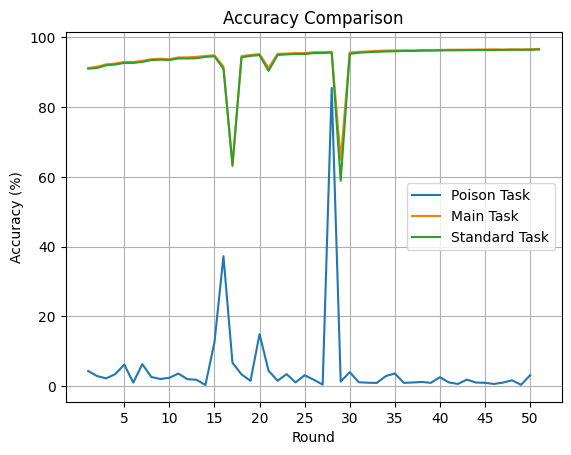

In [59]:
print(len(main_acc_values))
global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_accuracy_distributed = history.metrics_distributed["accuracy"]

# Rút trích thông tin từ dữ liệu
# round_centralised = [data[0] for data in global_accuracy_centralised]
round_distributed = [data[0] for data in global_accuracy_distributed]

# Vẽ đồ thị
# plt.plot(range(1, 52), [data[1] for data in global_accuracy_centralised], label="Poison Task")
plt.plot(range(1, 51), [data[1] for data in global_accuracy_distributed], label="Poison Task")
plt.plot(range(1, 52), main_acc_values, label="Main Task")
plt.plot(range(1, 52), standard_acc_values, label="Standard Task")

# Thiết lập định dạng của biểu đồ
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("Accuracy Comparison")
plt.legend()
xticks_result = plt.xticks(range(5, 52, 5))
# xticks_result = plt.xticks(range(1, 52))


history.metrics_centralized = {'accuracy': [(0, 2.7131782945736433), (1, 2.7131782945736433), (2, 2.7131782945736433), (3, 2.616279069767442), (4, 2.5193798449612403), (5, 2.616279069767442), (6, 2.5193798449612403), (7, 2.3255813953488373), (8, 2.3255813953488373), (9, 2.4224806201550386), (10, 2.3255813953488373), (11, 2.4224806201550386), (12, 2.5193798449612403), (13, 2.3255813953488373), (14, 2.3255813953488373), (15, 8.430232558139535), (16, 30.426356589147286), (17, 3.197674418604651), (18, 2.3255813953488373), (19, 2.3255813953488373), (20, 12.015503875968992), (21, 2.616279069767442), (22, 1.8410852713178294), (23, 1.8410852713178294), (24, 2.4224806201550386), (25, 1.8410852713178294), (26, 1.8410852713178294), (27, 1.550387596899225), (28, 86.53100775193798), (29, 2.616279069767442), (30, 1.550387596899225), (31, 1.550387596899225), (32, 1.550387596899225), (33, 1.550387596899225), (34, 1.4534883720930232), (35, 1.4534883720930232), (36, 1.3565891472868217), (37, 1.356589147

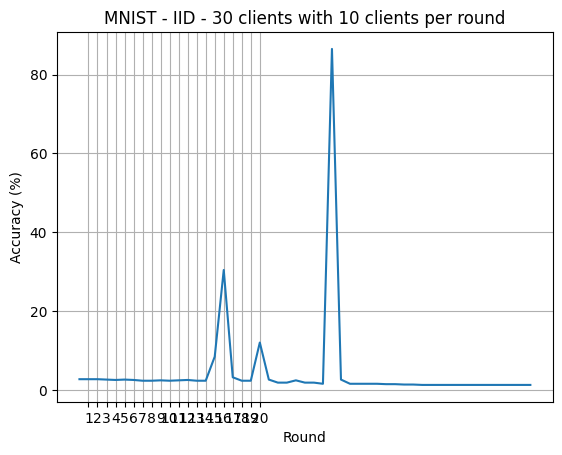

In [60]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")
# print(f"{history.metrics_distributed = }")


global_accuracy_centralised = history.metrics_centralized["accuracy"]
# global_accuracy_centralised = history.metrics_distributed["accuracy"]

round = [data[0] for data in global_accuracy_centralised]
acc = [data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 30 clients with 10 clients per round")
xticks_result = plt.xticks(range(1, 21))
# plt.yticks(range(0, 100))